In [39]:
!pip install segmentation-models-pytorch

In [40]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim

import segmentation_models_pytorch as smp

In [41]:
DATASET_FILEPATH = Path('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

In [42]:
IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

In [43]:
df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [44]:
feats = ['filename', 'mask']

df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [45]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    
    image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
    mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))
    
    resized_image = cv2.resize(image, (new_size, new_size))
    resized_mask = cv2.resize(mask, (new_size, new_size))
    
    to_rgb = cv2.COLOR_BGR2RGB
    
    resized_image = cv2.cvtColor(resized_image, to_rgb)
    resized_mask = cv2.cvtColor(resized_mask, to_rgb)
    
    return resized_image, resized_mask

In [46]:
list_of_an_images = sorted([i for i in Path(IMAGES_FILEPATH).iterdir()])
list_of_a_masks = sorted([i for i in Path(MASKS_FILEPATH).iterdir()])

In [47]:
len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [48]:
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28594 non-null  object
 1   mask      28594 non-null  object
dtypes: object(2)
memory usage: 446.9+ KB


In [49]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [50]:
IMG_SIZE = 256

In [51]:
class LipsDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, preprocessing=None):
        
        self.data = data
        self.preprocessing = preprocessing
        
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)
        
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2, 0, 1)
        
        cls_mask_1 = np.where(mask > 50, 0, 255)[:,:,1]
        cls_mask_2 = np.where(cls_mask_1 > 0, 0, 255)
        
        cls_mask_1 = cls_mask_1.astype('float')
        cls_mask_2 = cls_mask_2.astype('float')
        
        cls_mask_1 /= 255.0
        cls_mask_2 /= 255.0
            
        masks = [cls_mask_1, cls_mask_2]
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        
        return img.float(), masks

In [52]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.3,random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train)
valid_data = LipsDataset(X_valid)

In [53]:
dl_train = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
dl_valid = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

In [54]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        self.pool = nn.MaxPool2d(kernel_size=2, 
                                      stride=2)
        
        self.down_conv_1 = self.conv_block(in_channels=3, 
                                          out_channels=64)
        self.down_conv_2 = self.conv_block(in_channels=64, 
                                           out_channels=128)
        self.down_conv_3 = self.conv_block(in_channels=128, 
                                           out_channels=256)
        self.down_conv_4 = self.conv_block(in_channels=256, 
                                           out_channels=512)
        self.middle_conv = self.conv_block(in_channels=512, 
                                           out_channels=1024)
        
        
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, 
                                             out_channels=512,
                                             kernel_size=3,
                                             stride=2,
                                             padding=1, 
                                             output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, 
                                          out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, 
                                             out_channels=256, 
                                             kernel_size=3,
                                             stride=2,
                                             padding=1, 
                                             output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, 
                                          out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, 
                                             out_channels=128,
                                             kernel_size=3,
                                             stride=2,
                                             padding=1, 
                                             output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, 
                                          out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, 
                                             out_channels=64,
                                             kernel_size=3,
                                             stride=2,
                                             padding=1, 
                                             output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, 
                                          out_channels=64)
        self.output = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=self.num_classes,
                                         kernel_size=3,
                                         stride=1,
                                         padding=1)
        self.softmax = nn.Softmax()
        
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels, 
                      out_channels=out_channels, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels)
        )
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:,:, delta:tensor_size - delta, delta:tensor_size - delta]

    
    def forward(self, X):
        
        x_1 = self.down_conv_1(X)
        x_2 = self.pool(x_1)
        x_3 = self.down_conv_2(x_2)
        x_4 = self.pool(x_3)
        x_5 = self.down_conv_3(x_4)
        x_6 = self.pool(x_5)
        x_7 = self.down_conv_4(x_6)
        x_8 = self.pool(x_7)
        
        middle_out = self.middle_conv(x_8)
        
        x = self.up_conv_11(middle_out)
        y = self.crop_tensor(x, x_7)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_12(x)
        
        x = self.up_conv_21(x)
        y = self.crop_tensor(x, x_5)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_22(x)
        
        x = self.up_conv_31(x)
        y = self.crop_tensor(x, x_3)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_32(x)
        
        x = self.up_conv_41(x)
        y = self.crop_tensor(x, x_1)
        x = torch.cat((x, y), dim=1)
        x = self.up_conv_42(x)
        
        output = self.output(x)
        output = self.softmax(output)
        
        return output

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [56]:
model = Net(num_classes=2).to(device)

In [57]:
sample = (next(iter(dl_train)))
sample[0].shape

torch.Size([8, 3, 256, 256])

In [58]:
optimizer = optim.Adam(model.parameters())

In [59]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        
        smooth = 1
        
        num = targets.size(0)
        probs = logits
        
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        
        return score

In [60]:
criterion = DiceLoss()

In [61]:
epochs = 1

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = []
    
    for batch_idx, (data, labels) in enumerate(dl_train):
        
        data, labels = data.to(device), labels.to(device)        
        
        optimizer.zero_grad()
        outputs = model(data)                
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx % 500 == 0:
            print(f'batch index : {batch_idx}, loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    end_time = time.time()
    print(f'Spend time for 1 epoch: {start_time - end_time} sec')
    
    epoch_losses.append(epoch_loss)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


batch index : 0, loss : 0.4393843412399292
batch index : 500, loss : 0.0014820098876953125
batch index : 1000, loss : 0.007756471633911133
batch index : 1500, loss : 0.0016339421272277832
batch index : 2000, loss : 0.001762688159942627
Epoch 1, loss:  0.004280504438760664
Spend time for 1 epoch: -2254.3085432052612 sec


In [62]:
data_iter = iter(dl_valid)

In [63]:
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = model(images)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


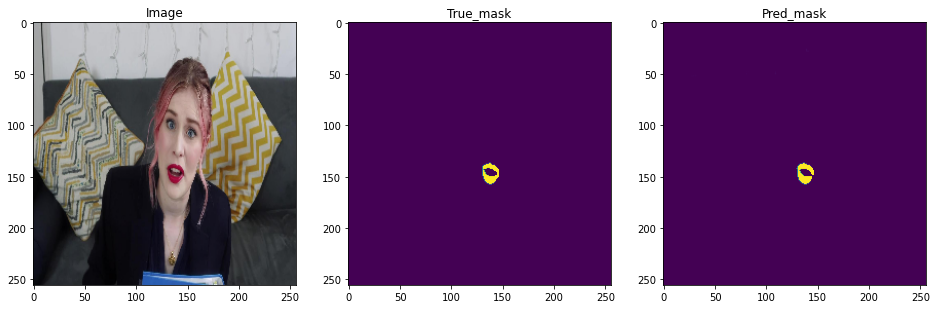

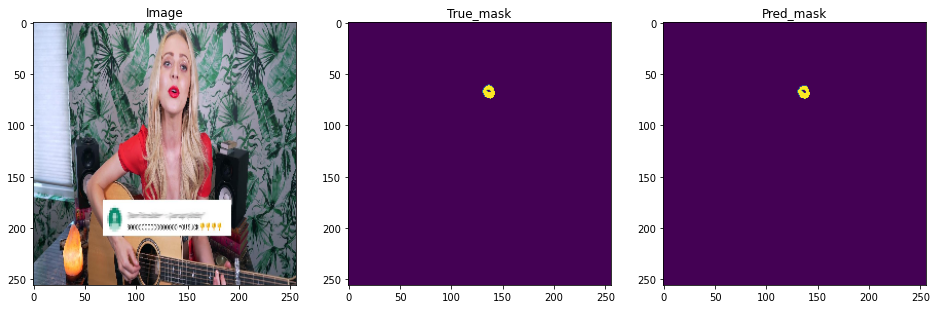

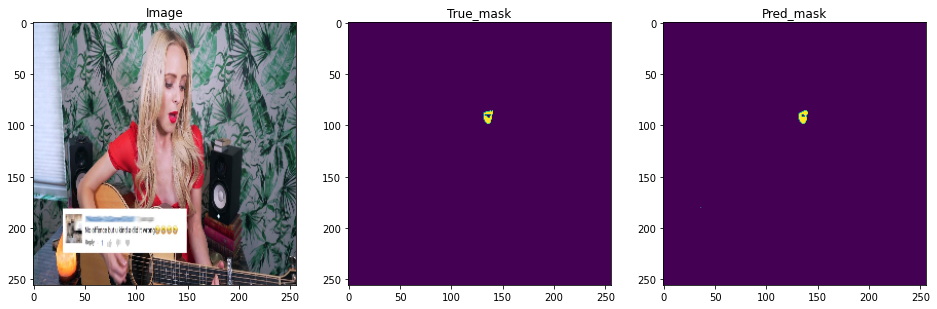

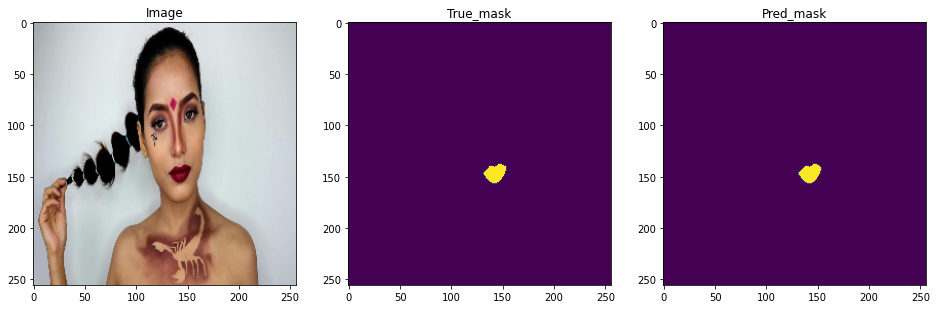

In [64]:
for i in range(images.shape[0]):
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, 1,:,:].cpu())
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu().numpy()[i, 1,:,:])
    ax_3.set_title('Pred_mask')
    
    plt.show()

In [65]:
BACKBONE = 'resnet34'

segmodel = smp.Linknet(encoder_name=BACKBONE, classes=2, activation='softmax')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

In [66]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.3,random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [67]:
dl_train = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
dl_valid = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

In [68]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters())

In [69]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [70]:
# train model

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(dl_train)
    valid_logs = valid_epoch.run(dl_valid)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
train:   0%|          | 1/2498 [00:00<21:42,  1.92it/s, dice_loss - 0.6128, iou_score - 0.1287]

/opt/conda/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|██████████| 2141/2141 [08:39<00:00,  4.12it/s, dice_loss - 0.0005532, iou_score - 0.9991]
Model saved!


In [71]:
data_iter = iter(dl_valid)

In [72]:
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

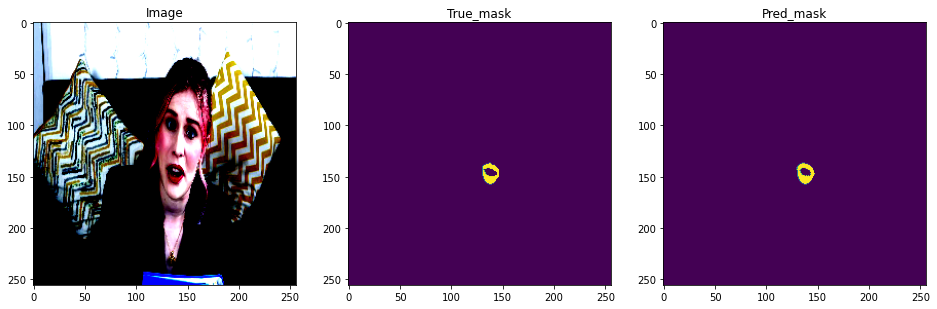

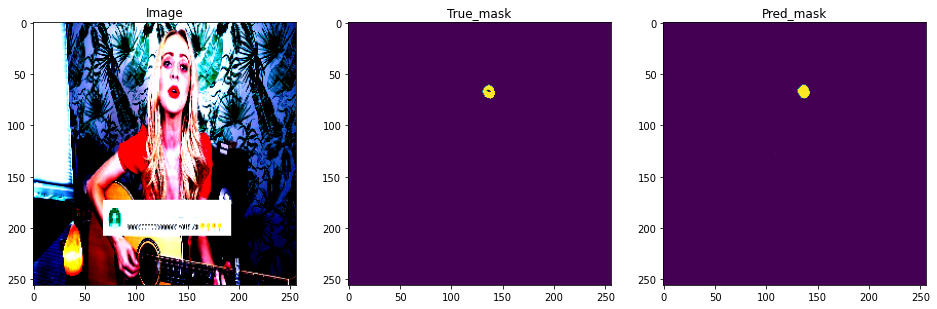

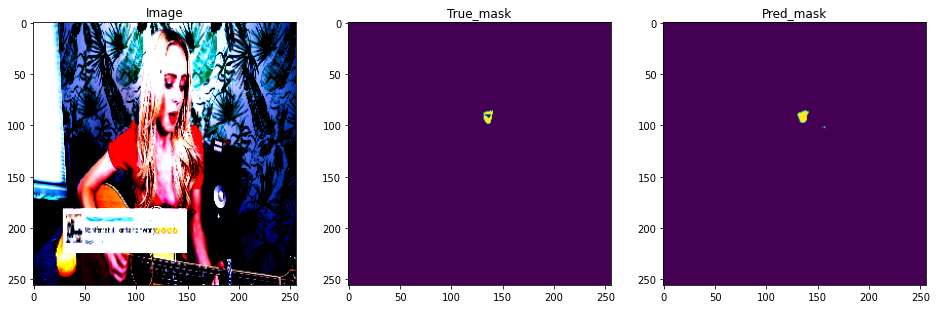

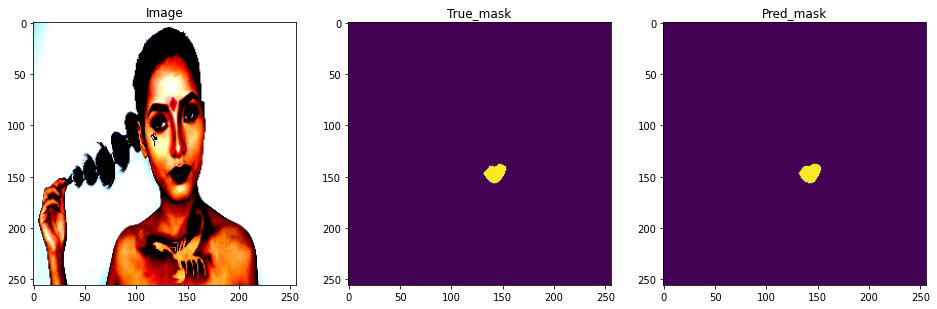

In [73]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, 1,:,:].cpu())
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu().numpy()[i, 1,:,:])
    ax_3.set_title('Pred_mask')